News head:
        date  count  total_count
0 2020-11-06    190        17408
1 2020-11-07     85        10276
2 2020-11-08     62         9675
3 2020-11-09    430        18127
4 2020-11-10    251        19509
News shape: (1860, 3)


[*********************100%***********************]  1 of 1 completed



SPX head:
Price       date         open        close
0     2020-12-15  3666.409912  3694.620117
1     2020-12-16  3696.250000  3701.169922
2     2020-12-17  3713.649902  3722.479980
3     2020-12-18  3722.389893  3709.409912
4     2020-12-21  3684.280029  3694.919922
SPX shape: (1255, 3)

Merged head:
        date  count  total_count         open        close
0 2020-12-15    194        18172  3666.409912  3694.620117
1 2020-12-16    212        17967  3696.250000  3701.169922
2 2020-12-17    195        16800  3713.649902  3722.479980
3 2020-12-18    208        16474  3722.389893  3709.409912
4 2020-12-21    265        15961  3684.280029  3694.919922
Merged shape: (1252, 5)

Merged with Gain_Loss head:
        date  count  total_count         open        close  Gain_Loss
0 2020-12-15    194        18172  3666.409912  3694.620117       0.77
1 2020-12-16    212        17967  3696.250000  3701.169922       0.13
2 2020-12-17    195        16800  3713.649902  3722.479980       0.24
3 2020-12

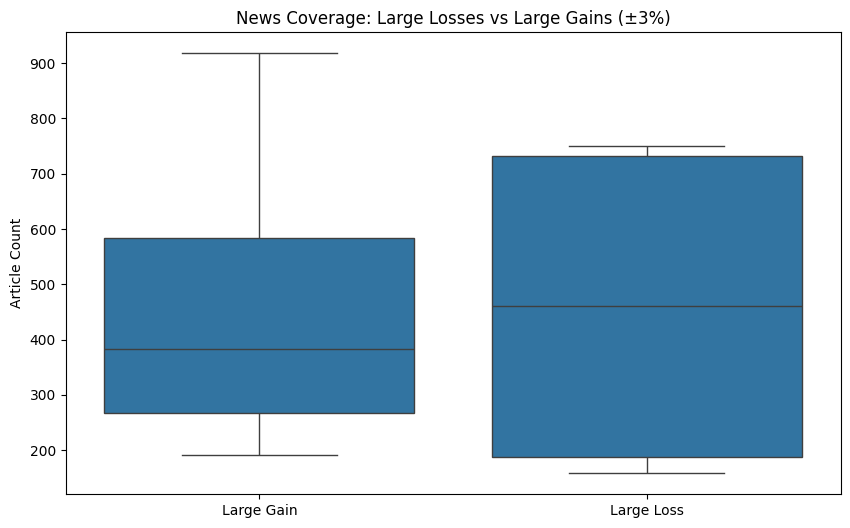


LAG RESULTS AFTER LARGE LOSSES (≤ -3%):
            Lag  Average_Articles
0      Same Day            457.75
1   1 Day After            437.50
2  2 Days After            354.50
3  3 Days After            305.50


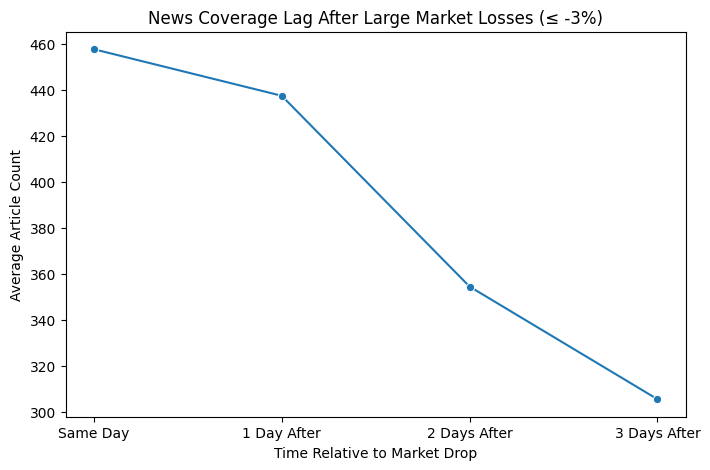


LIKE-FOR-LIKE SUMMARY (±2.5%):
              Move_Type  N_Days  Mean_Articles  Median_Articles
0  Large Loss (≤ -2.5%)      13     263.769231            197.0
1  Large Gain (≥ +2.5%)       7     351.857143            292.0


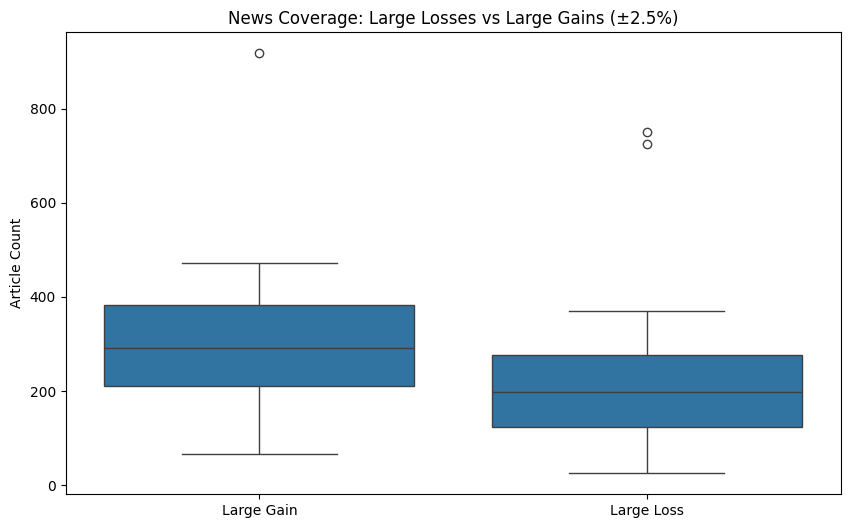

In [1]:
# --------------------------------------------
# PROJECT: Do markets get more news coverage on big down days?
# DATA: MediaCloud daily article counts + S&P 500 (yfinance)
# --------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# --------------------------------------------
# 1) LOAD NEWSDATA (MEDIACLOUD)
# --------------------------------------------

# Update this path to wherever your CSV is stored
news_path = r"C:\Data\S&P FTSE News Artical\mc-onlinenews-mediacloud-20251210204328-counts.csv"
news = pd.read_csv(news_path)

# Ensure datetime
news["date"] = pd.to_datetime(news["date"])

# Drop columns you don't need (keep count + total_count for context)
# Note: your comment says “drop total_count and ratio” but your code drops only ratio
# This keeps total_count in case you want to normalise later.
news = news.drop(columns=["ratio"], errors="ignore")

print("News head:")
print(news.head())
print("News shape:", news.shape)

# --------------------------------------------
# 2) LOAD MARKET DATA (S&P 500)
# --------------------------------------------

spx = yf.download("^GSPC", period="5y", interval="1d", auto_adjust=False)
spx = spx.reset_index()

# yfinance sometimes returns multi-index columns depending on version
if isinstance(spx.columns, pd.MultiIndex):
    spx.columns = spx.columns.droplevel(1)

spx = spx[["Date", "Open", "Close"]].rename(columns={
    "Date": "date",
    "Open": "open",
    "Close": "close"
})

spx["date"] = pd.to_datetime(spx["date"])

print("\nSPX head:")
print(spx.head())
print("SPX shape:", spx.shape)

spx.to_csv("spx_raw.csv", index=False)

# --------------------------------------------
# 3) MERGE DATASETS
# --------------------------------------------

full_data = news.merge(spx, on="date", how="inner")

print("\nMerged head:")
print(full_data.head())
print("Merged shape:", full_data.shape)

# --------------------------------------------
# 4) FEATURE: DAILY % RETURN (OPEN->CLOSE)
# --------------------------------------------

full_data["Gain_Loss"] = ((full_data["close"] - full_data["open"]) / full_data["open"]) * 100
full_data["Gain_Loss"] = full_data["Gain_Loss"].round(2)

print("\nMerged with Gain_Loss head:")
print(full_data.head())

# --------------------------------------------
# 5) INITIAL CHECK: TOP 20 GAINS VS TOP 20 LOSSES (EXPLORATORY)
# --------------------------------------------

top_20_gains = full_data.sort_values("Gain_Loss", ascending=False).head(20)
top_20_losses = full_data.sort_values("Gain_Loss", ascending=True).head(20)

print("\nTop 20 gains:")
print(top_20_gains[["date", "count", "Gain_Loss"]])

print("\nTop 20 losses:")
print(top_20_losses[["date", "count", "Gain_Loss"]])

print("\nMean article count (top 20 gains):", round(top_20_gains["count"].mean(), 2))
print("Mean article count (top 20 losses):", round(top_20_losses["count"].mean(), 2))

# NOTE:
# This approach can be distorted by rare extreme outliers (e.g., very large up days).
# We refine the test using like-for-like thresholds.

# --------------------------------------------
# 6) REFINED TEST 1: LIKE-FOR-LIKE (±3%)
# --------------------------------------------

def like_for_like_summary(df, threshold):
    losses = df[df["Gain_Loss"] <= -threshold]
    gains = df[df["Gain_Loss"] >= threshold]

    summary = pd.DataFrame({
        "Move_Type": [f"Large Loss (≤ -{threshold}%)", f"Large Gain (≥ +{threshold}%)"],
        "N_Days": [len(losses), len(gains)],
        "Mean_Articles": [losses["count"].mean(), gains["count"].mean()],
        "Median_Articles": [losses["count"].median(), gains["count"].median()]
    })
    return losses, gains, summary

loss_3, gain_3, summary_3 = like_for_like_summary(full_data, 3)
print("\nLIKE-FOR-LIKE SUMMARY (±3%):")
print(summary_3)

# Visual comparison (±3%)
if len(loss_3) > 0 and len(gain_3) > 0:
    plot_df = full_data[(full_data["Gain_Loss"] <= -3) | (full_data["Gain_Loss"] >= 3)].copy()
    plot_df["Move_Type"] = plot_df["Gain_Loss"].apply(lambda x: "Large Loss" if x <= -3 else "Large Gain")

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=plot_df, x="Move_Type", y="count")
    plt.title("News Coverage: Large Losses vs Large Gains (±3%)")
    plt.xlabel("")
    plt.ylabel("Article Count")
    plt.show()

# --------------------------------------------
# 7) LAG ANALYSIS: DO ARTICLES PEAK AFTER BIG LOSSES?
# --------------------------------------------

full_data = full_data.sort_values("date")

for lag in range(1, 4):
    full_data[f"count_lag_{lag}"] = full_data["count"].shift(lag)

loss_days_3 = full_data[full_data["Gain_Loss"] <= -3]

lag_results_3 = pd.DataFrame({
    "Lag": ["Same Day", "1 Day After", "2 Days After", "3 Days After"],
    "Average_Articles": [
        loss_days_3["count"].mean(),
        loss_days_3["count_lag_1"].mean(),
        loss_days_3["count_lag_2"].mean(),
        loss_days_3["count_lag_3"].mean()
    ]
})

print("\nLAG RESULTS AFTER LARGE LOSSES (≤ -3%):")
print(lag_results_3)

plt.figure(figsize=(8, 5))
sns.lineplot(data=lag_results_3, x="Lag", y="Average_Articles", marker="o")
plt.title("News Coverage Lag After Large Market Losses (≤ -3%)")
plt.xlabel("Time Relative to Market Drop")
plt.ylabel("Average Article Count")
plt.show()

# --------------------------------------------
# 8) REFINED TEST 2: EXPANDED THRESHOLD (±2.5%) FOR LARGER SAMPLE
# --------------------------------------------

loss_25, gain_25, summary_25 = like_for_like_summary(full_data, 2.5)
print("\nLIKE-FOR-LIKE SUMMARY (±2.5%):")
print(summary_25)

# Optional: boxplot for ±2.5%
if len(loss_25) > 0 and len(gain_25) > 0:
    plot_df2 = full_data[(full_data["Gain_Loss"] <= -2.5) | (full_data["Gain_Loss"] >= 2.5)].copy()
    plot_df2["Move_Type"] = plot_df2["Gain_Loss"].apply(lambda x: "Large Loss" if x <= -2.5 else "Large Gain")

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=plot_df2, x="Move_Type", y="count")
    plt.title("News Coverage: Large Losses vs Large Gains (±2.5%)")
    plt.xlabel("")
    plt.ylabel("Article Count")
    plt.show()

# --------------------------------------------
# 9) INTERPRETATION NOTES (FOR README)
# --------------------------------------------

# - The “Top 20” comparison is exploratory and sensitive to outliers.
# - Like-for-like thresholds help compare moves of similar magnitude.
# - Mean vs median can disagree when article counts are skewed.
# - Lag analysis tests whether coverage peaks 1–3 days after big losses.
# - Expanding the threshold increases sample size and stabilises conclusions.
